<a href="https://colab.research.google.com/github/YoheiFukuhara/recommender-system/blob/main/06_mf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from datetime import datetime
import pickle

from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE_PATH = '/content/drive/MyDrive/ColabNotebooks/ML/Recommend/output/'

In [ ]:
def load_pickle(file):
    with open(BASE_PATH+file+'.pickle', 'rb') as f:
        return pickle.load(f)

user2movie = load_pickle('user2movie')
movie2user = load_pickle('movie2user')
usermovie2rating = load_pickle('usermovie2rating')
usermovie2rating_test = load_pickle('usermovie2rating_test')

In [ ]:
N = np.max(list(user2movie.keys())) + 1
m1 = np.max(list(movie2user.keys()))
m2 = np.max([m for (u, m), r in usermovie2rating_test.items()])
M = max(m1, m2) + 1
print('N:', N, 'M:', M)  #if N is more than 10000, it takes so much time to process.

N: 4000 M: 1000


In [ ]:
K = 10 # dimension
W = np.random.randn(N, K)
b = np.zeros(N)
U = np.random.randn(M, K)
c = np.zeros(M)
mu = np.mean(list(usermovie2rating.values()))

In [ ]:
def get_loss(d):
    # d: (user_id, movie_id) -> rating
    # Sum of Squared Error
    sse = 0  
    for k, r in d.items():
        i, j = k
        pred = W[i].dot(U[j]) + b[i] + c[j] + mu
        sse += (pred - r)*(pred - r)
    return sse / float(len(d))

In [ ]:
%%time
# train the parameters
epochs = 12  # change from original 25
reg =20. # regularization penalty
train_losses = []
test_losses = []

for epoch in range(epochs):
    print(f"epoch:{epoch}")
    
    # perform updates
    epoch_start = datetime.now()

    # update W and b
    t0 = datetime.now()
    for i in range(N):
        # for W
        matrix = np.eye(K) * reg  # np.eyeは単位行列(ここではK*K)
        vector = np.zeros(K)

        # for b
        bi = 0
        for j in user2movie[i]:
            r = usermovie2rating[(i,j)]
            matrix += np.outer(U[j], U[j]) # np.outer は外積
            vector += (r - b[i] - c[j] - mu)*U[j]
            bi += (r - W[i].dot(U[j]) - c[j] - mu)

        # set the updates
        W[i] = np.linalg.solve(matrix, vector)
        b[i] = bi / (len(user2movie[i]) + reg)

        if i % (N//3) == 0:
            print("i:", i, "N:", N)
    print("updated W and b:", datetime.now() - t0)

    # update U and c
    t0 = datetime.now()
    for j in range(M):
        # for U
        matrix = np.eye(K) * reg
        vector = np.zeros(K)

        # for c
        cj = 0
        try:
            for i in movie2user[j]:
                r = usermovie2rating[(i,j)]
                matrix += np.outer(W[i], W[i])
                vector += (r - b[i] - c[j] - mu)*W[i]
                cj += (r - W[i].dot(U[j]) - b[i] - mu)

                # set the updates
                U[j] = np.linalg.solve(matrix, vector)
                c[j] = cj / (len(movie2user[j]) + reg)

            if j % (M//3) == 0:
                print("j:", j, "M:", M)
        except KeyError:
            # possible not to have any ratings for a movie
            pass
    print("updated U and c:", datetime.now() - t0)
    print("epoch duration:", datetime.now() - epoch_start)


    # store train loss
    t0 = datetime.now()
    train_losses.append(get_loss(usermovie2rating))

    # store test loss
    test_losses.append(get_loss(usermovie2rating_test))
    print("calculate cost:", datetime.now() - t0)
    print("train loss:", train_losses[-1])
    print("test loss:", test_losses[-1])

epoch:0
i: 0 N: 4000
i: 1333 N: 4000
i: 2666 N: 4000
i: 3999 N: 4000
updated W and b: 0:00:28.672946
j: 0 M: 1000
j: 333 M: 1000
j: 666 M: 1000
j: 999 M: 1000
updated U and c: 0:00:58.616507
epoch duration: 0:01:27.289621
calculate cost: 0:00:04.977027
train loss: 0.6819014731854192
test loss: 0.6947537514263058
epoch:1
i: 0 N: 4000
i: 1333 N: 4000
i: 2666 N: 4000
i: 3999 N: 4000
updated W and b: 0:00:27.532615
j: 0 M: 1000
j: 333 M: 1000
j: 666 M: 1000
j: 999 M: 1000
updated U and c: 0:01:00.732173
epoch duration: 0:01:28.265265
calculate cost: 0:00:04.838404
train loss: 0.5406150251654824
test loss: 0.5737171756140579
epoch:2
i: 0 N: 4000
i: 1333 N: 4000
i: 2666 N: 4000
i: 3999 N: 4000
updated W and b: 0:00:28.301212
j: 0 M: 1000
j: 333 M: 1000
j: 666 M: 1000
j: 999 M: 1000
updated U and c: 0:01:00.161846
epoch duration: 0:01:28.463221
calculate cost: 0:00:04.862644
train loss: 0.511632634341426
test loss: 0.5478242908373959
epoch:3
i: 0 N: 4000
i: 1333 N: 4000
i: 2666 N: 4000
i: 399

train losses: [0.6819014731854192, 0.5406150251654824, 0.511632634341426, 0.506182572425836, 0.5045748475656893, 0.5039978339768592, 0.5036848235542332, 0.5035174825636282, 0.5033961674909901, 0.5033124367868115, 0.5032427728212927, 0.5031882511016134]
test losses: [0.6947537514263058, 0.5737171756140579, 0.5478242908373959, 0.542070636363171, 0.5402397450057262, 0.5394811659163323, 0.5390180476429646, 0.5387373464856462, 0.5385120128463278, 0.5383467044133589, 0.5382040900025029, 0.538092858967583]


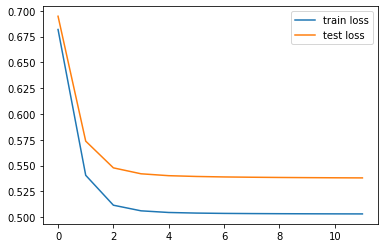

In [ ]:
print("train losses:", train_losses)
print("test losses:", test_losses)

# plot losses
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()